In [1]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.transform import downscale_local_mean, rotate
import numpy as np
import os
import tifffile
from scipy import ndimage
import time
import torch
from torch.utils.data import Dataset, DataLoader
#import dataloader1 as dataloader
import dataloader as dataloader
import cv2
import skimage

In [2]:

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {device_count}")
    for i in range(device_count):
        device = torch.cuda.get_device_name(i)
        print(f"Device {i}: {device}")
else:
    print("CUDA is not available on this machine.")

Number of CUDA devices available: 1
Device 0: Quadro RTX 4000


In [3]:
patch_size = 64
batch_size = 1

In [4]:
# Set the paths to data and target files
train_files = [
    ('01_Substack (7882-8277)_B45_bag5_.tif','registered_image01_3dCT_B45_bag5_100mm.tif'),
    #('02_Substack (6267-6662)_B40_bag12_13.tif','registered_image02_3dCT_B40_bag12_13_300mm.tif' ),
    ('03_Substack (6241-6635)_B40_bag22_23.tif', 'registered_image03_3dCT_B40_bag22_23_300mmLUT.tif' ),
    ('04_Substack (7285-7546)_B40_bag32_33.tif','registered_image04_3dCT_B40_bag32_33_200mm_Substack(396-1440).tif' ),
    ('05_Substack (6292-6686)_B40_bag46_47.tif','registered_image05_3dCT_B40_bag46_47_300mm.tif'),
    #('06_Substack (8055-8449)_B40_bag56_57.tif','registered_image06_3dCT_B40_bag56_57_100mm.tif' ),
    ('07_Substack (5525-5920)_B40_bag66_67.tif', 'registered_image07_3dCT_B40_bag66_67_400mm.tif' ),
    ('08_Substack (3424-3818)_B40_bag86_87.tif', 'registered_image08_3dCT_B40_bag86_87_640mm.tif' ),
    ('09_Substack (3098-3490)_B40_bag96_97.tif', 'registered_image09_3dCT_B40_bag96_97_675mm.tif' ),
    #('10_Substack (4268-4663)_B40_bag108_109.tif','registered_image10_3dCT_B40_bag108_109_538mm.tif'),
    ('11_Substack (305-698)_B40_bag126_127.tif', 'registered_image11_3dCT_B40_bag126_127_1002mm.tif')
    ]

test_files = [
    #('01_Substack (7882-8277)_B45_bag5_.tif','registered_image01_3dCT_B45_bag5_100mm.tif'),
    ('02_Substack (6267-6662)_B40_bag12_13.tif','registered_image02_3dCT_B40_bag12_13_300mm.tif' ),
    #('03_Substack (6241-6635)_B40_bag22_23.tif', 'registered_image03_3dCT_B40_bag22_23_300mmLUT.tif' ),
    #('04_Substack (7285-7546)_B40_bag32_33.tif','registered_image04_3dCT_B40_bag32_33_200mm_Substack(396-1440).tif' ),
    #('05_Substack (6292-6686)_B40_bag46_47.tif','registered_image05_3dCT_B40_bag46_47_300mm.tif'),
    ('06_Substack (8055-8449)_B40_bag56_57.tif','registered_image06_3dCT_B40_bag56_57_100mm.tif' ),
    #('07_Substack (5525-5920)_B40_bag66_67.tif', 'registered_image07_3dCT_B40_bag66_67_400mm.tif' ),
    #('08_Substack (3424-3818)_B40_bag86_87.tif', 'registered_image08_3dCT_B40_bag86_87_640mm.tif' ),
    #('09_Substack (3098-3490)_B40_bag96_97.tif', 'registered_image09_3dCT_B40_bag96_97_675mm.tif' ),
    ('10_Substack (4268-4663)_B40_bag108_109.tif','registered_image10_3dCT_B40_bag108_109_538mm.tif'),
    #('11_Substack (305-698)_B40_bag126_127.tif', 'registered_image11_3dCT_B40_bag126_127_1002mm.tif')
    ]

In [5]:
# If need to generate pathes for the firs time then put true for the need_patches
train_dataset = dataloader.microCT_Dataset(train_files,train_or_test = 'train',
                                         HR_patch_size=patch_size,
                                         transform = None,
                                          need_patches=False)

In [6]:
train_data_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

In [7]:
# Create an iterator for the DataLoader
data_iter = iter(train_data_loader)



Input Data Shape: torch.Size([1, 1, 64, 64, 64])
Target Shape: torch.Size([1, 1, 64, 64, 64])
tensor(225.7500)
mask (64, 64)
(64, 64)


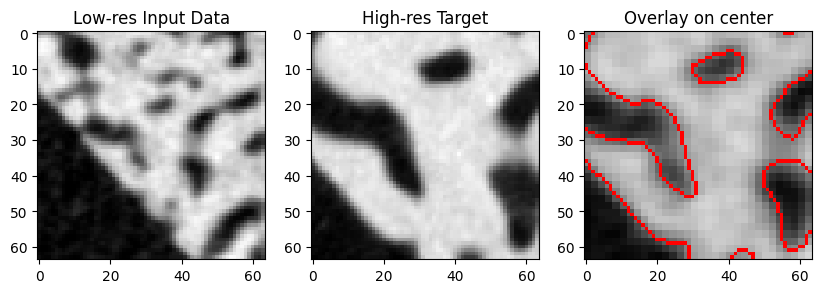

In [8]:
# Get one batch (one sample) from the iterator
sample_batch = next(data_iter)

# Extract input and target from the sample batch
input_data, target = sample_batch

# Now, you have one sample of input data and its corresponding target
print("Input Data Shape:", input_data.shape)
print("Target Shape:", target.shape)

input_image = input_data[0,0,16,:,:]
target_image = target[0,0,0,:,:]

print (input_image.max())
# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Plot input image

axes[0].imshow(input_image, cmap='gray') 
axes[0].set_title('Low-res Input Data')
#axes[0].axis('off')

# Plot target image
axes[1].imshow(target_image, cmap='gray')  # Assuming target is grayscale
axes[1].set_title('High-res Target')
#axes[1].axis('off')

zoom = int(patch_size/4)
input_image = input_image[zoom:-zoom,zoom:-zoom]
input_image = ndimage.zoom(input_image,2, order = 0, prefilter=False, grid_mode=False)

#target_image_paded = np.pad(target_image,((zoom,zoom),(zoom,zoom)))
mask = np.zeros_like(target_image, dtype='uint8')

thresh = 70
mask[target_image>=thresh] = 1
mask[target_image<thresh] = 0
print ('mask' ,mask.shape)
input_image = input_image.astype('uint8')
print (input_image.shape)
overlay = mark_boundaries(input_image, mask, color=(1, 0, 0))
axes[2].imshow(overlay)  # Assuming target is grayscale
axes[2].set_title('Overlay on center')

plt.show()

In [9]:

# If need to generate pathes for the firs time then put true for the need_patches
test_dataset = dataloader.microCT_Dataset(test_files,train_or_test = 'test',
                                         HR_patch_size=patch_size,
                                         transform = None,
                                          need_patches=False)


In [10]:
test_data_loader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              shuffle=True)

In [11]:
# Create an iterator for the DataLoader
data_iter = iter(test_data_loader)


Input Data Shape: torch.Size([1, 1, 64, 64, 64])
Target Shape: torch.Size([1, 1, 64, 64, 64])
tensor(235.1250)
mask (64, 64)
(64, 64)


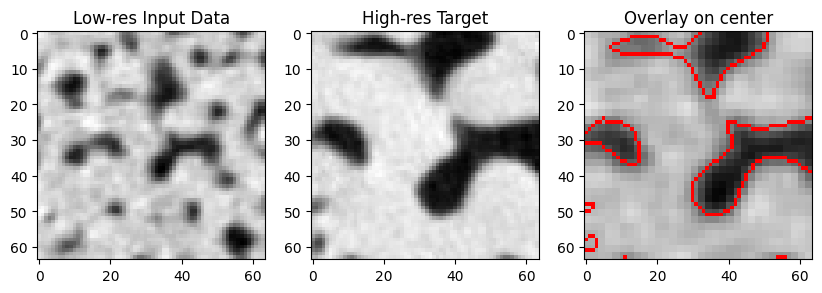

In [12]:
# Get one batch (one sample) from the iterator
sample_batch = next(data_iter)

# Extract input and target from the sample batch
input_data, target = sample_batch

# Now, you have one sample of input data and its corresponding target
print("Input Data Shape:", input_data.shape)
print("Target Shape:", target.shape)

input_image = input_data[0,0,16,:,:]
target_image = target[0,0,0,:,:]

print (input_image.max())
# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Plot input image

axes[0].imshow(input_image, cmap='gray') 
axes[0].set_title('Low-res Input Data')
#axes[0].axis('off')

# Plot target image
axes[1].imshow(target_image, cmap='gray')  # Assuming target is grayscale
axes[1].set_title('High-res Target')
#axes[1].axis('off')

zoom = int(patch_size/4)
input_image = input_image[zoom:-zoom,zoom:-zoom]
input_image = ndimage.zoom(input_image,2, order = 0, prefilter=False, grid_mode=False)

#target_image_paded = np.pad(target_image,((zoom,zoom),(zoom,zoom)))
mask = np.zeros_like(target_image, dtype='uint8')

thresh = 70
mask[target_image>=thresh] = 1
mask[target_image<thresh] = 0
print ('mask' ,mask.shape)
input_image = input_image.astype('uint8')
print (input_image.shape)
overlay = mark_boundaries(input_image, mask, color=(1, 0, 0))
axes[2].imshow(overlay)  # Assuming target is grayscale
axes[2].set_title('Overlay on center')

plt.show()

In [13]:
round(len(test_dataset)*100/len(train_dataset))

40